<a href="https://colab.research.google.com/github/parsa-abbasi/Sentiment-Analysis/blob/master/Multiclass-Classification/DL_FastTextEmb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

## Install required libraries

In [1]:
!pip install matplotlib==3.1.0

In [2]:
!pip install hazm
!pip install stopwords_guilannlp

## Get FastText

Download FastText word vectors file for Persian

(The list of all model vector files are available [here](https://fasttext.cc/docs/en/pretrained-vectors.html))

In [3]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fa.vec

--2020-01-01 13:21:29--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fa.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1105157170 (1.0G) [binary/octet-stream]
Saving to: ‘wiki.fa.vec’

wiki.fa.vec         100%[===================>]   1.03G  26.0MB/s    in 41s     

2020-01-01 13:22:11 (25.8 MB/s) - ‘wiki.fa.vec’ saved [1105157170/1105157170]



## Import Libraries

In [4]:
# General
import numpy as np
import pandas as pd
import codecs
from google.colab import files
# Word Embedding
from gensim.models import KeyedVectors
# Keras
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding, Dropout
from keras.layers import GlobalMaxPool1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.utils.np_utils import to_categorical
from keras.metrics import categorical_accuracy
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Preprocessing
from stopwords_guilannlp import stopwords_output
from hazm import *
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import plot_model
# Measuring metrics
from sklearn.metrics import f1_score

Using TensorFlow backend.


# Upload dataset files

Upload dataset files to colab environment

In [5]:
uploaded = files.upload()

Saving balanced.csv to balanced.csv
Saving original.csv to original.csv
Saving test.csv to test.csv
Saving translation.csv to translation.csv



# Import & Analyze Dataset

In [0]:
test = pd.read_csv('test.csv', index_col=None, header=None, encoding="utf-8")

In [0]:
x_test = test[0]
y_test = test[1]

In [8]:
print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of testing sentence:  (1854,)
Number of testing label:  (1854,)


In [0]:
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [0]:
original = pd.read_csv('original.csv', index_col=None, header=None, encoding="utf-8")
balanced = pd.read_csv('balanced.csv', index_col=None, header=None, encoding="utf-8")
translation = pd.read_csv('translation.csv', index_col=None, header=None, encoding="utf-8")

In [0]:
selected_dataset = translation

In [0]:
selected_dataset = selected_dataset.sample(frac=1).reset_index(drop=True)

In [0]:
x_train = selected_dataset[0]
y_train = selected_dataset[1]

In [95]:
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)

Number of training sentence:  (14046,)
Number of training label:  (14046,)


In [0]:
# Convert dataframes to numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [97]:
# See the data number of sentence in each category 
from collections import Counter
cnt = Counter(y_train)
cnt = dict(cnt)
print(cnt)

{0: 4000, 2: 3856, 1: 4000, -2: 316, -1: 1874}


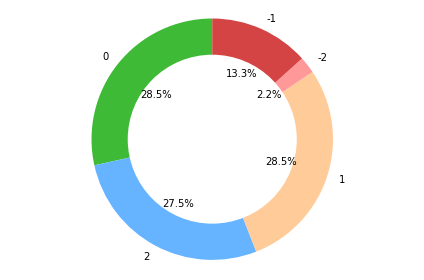

In [98]:
labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('distribution.png')
plt.show()

In [0]:
# Decomment following line if you want to download dataset figure
# files.download('distribution.png')

# Preprocess

In [0]:
puncs = ['،', '.', ',', ':', ';', '"']
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# turn a doc into clean tokens
def clean_doc(doc):
    doc = normalizer.normalize(doc) # Normalize document using Hazm Normalizer
    tokenized = word_tokenize(doc)  # Tokenize text
    tokens = []
    for t in tokenized:
      temp = t
      for p in puncs:
        temp = temp.replace(p, '')
      tokens.append(temp)
    # tokens = [w for w in tokens if not w in stop_set]    # Remove stop words
    tokens = [w for w in tokens if not len(w) <= 1]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # Lemmatize sentence words using Hazm Lemmatizer
    tokens = ' '.join(tokens)
    return tokens

# Prepare FastText Model

In [101]:
EMBEDDING_FILE = 'wiki.fa.vec'

def import_with_gensim(file_address):
  # Creating the model
  ft_model = KeyedVectors.load_word2vec_format(file_address)
  # Getting the tokens
  ft_words = []
  for ft_word in ft_model.vocab:
      ft_words.append(ft_word)
  return ft_model, ft_words
  
ft_model, ft_words = import_with_gensim(EMBEDDING_FILE)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# FastText embedding dimensionality
embed_size = 300

In [0]:
# We get the mean and standard deviation of the embedding weights so that we could maintain the
# same statistics for the rest of our own random generated weights.
embedding_list = list()
for w in ft_words:
  embedding_list.append(ft_model[w])

all_embedding = np.stack(embedding_list)
emb_mean, emb_std = all_embedding.mean(), all_embedding.std()

# Prepare data for Deep Learning model

## Apply preprocessing to data

In [0]:
# Apply preprocessing step to training data
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
  train_docs[index] = clean_doc(document)

In [0]:
# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_doc(document)

## Setting tokenizer up

In [0]:
num_words = 2000

# Create the tokenizer
tokenizer = Tokenizer(num_words=num_words)

# fFt the tokenizer on the training documents
tokenizer.fit_on_texts(train_docs)

In [0]:
# Find maximum length of training sentences
max_length = max([len(s.split()) for s in train_docs])

## Embed sentences

In [0]:
# Embed training sequences
encoded_docs = tokenizer.texts_to_sequences(train_docs)

# Pad embeded training sequences
x_train_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [0]:
# Define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index)

In [110]:
# We are going to set the embedding size to the pre-trained dimension as we are replicating it
nb_words = len(tokenizer.word_index)

# the size will be Number of Words in Vocab X Embedding Size
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

# With the newly created embedding matrix, we'll fill it up with the words that we have in both
# our own dictionary and loaded pre-trained embedding.
embeddedCount = 0
for word, i in tokenizer.word_index.items():
    i -= 1
    # then we see if this word is in glove's dictionary, if yes, get the corresponding weights
    if word in ft_model.vocab:
        embedding_vector = ft_model[word]
        # and store inside the embedding matrix that we will train later on.
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
    else:   # Unknown words
        embedding_vector = ft_model['subdivision_name']
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1

print('total embedded:', embeddedCount, 'common words')
print('Embedding matrix shape:', embedding_matrix.shape)

total embedded: 7774 common words
Embedding matrix shape: (7774, 300)


In [0]:
# Embed testing sequences
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# Pad testing sequences
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# Deep Learning Models

In [0]:
# Prepare labels for categorical prediction
categorical_y_train = to_categorical(y_train, 5)
categorical_y_test = to_categorical(y_test, 5)

## B-LSTM Model

In [0]:
model_blstm = Sequential()
model_blstm.add(Embedding(vocab_size, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=True))
model_blstm.add(Bidirectional(CuDNNLSTM(300, return_sequences=True, name='lstm_layer')))
model_blstm.add(GlobalMaxPool1D())
model_blstm.add(Dropout(0.2))
model_blstm.add(Dense(300, activation="relu"))
model_blstm.add(Dropout(0.1))
model_blstm.add(Dense(5, activation='softmax'))

In [146]:
model_blstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

model_blstm.summary()
batch_size_blstm = 64
epochs_blstm = 5

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 300)         2332200   
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 600)         1444800   
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 600)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 300)               180300    
_________________________________________________________________
dropout_14 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                

In [147]:
# Train model
hist_blstm = model_blstm.fit(x_train_padded, categorical_y_train, batch_size=batch_size_blstm, epochs=epochs_blstm, shuffle=True)

Epoch 1/5
14046/14046 [==============================] - 17s 1ms/step - loss: 1.2011 - categorical_accuracy: 0.4874
Epoch 2/5
14046/14046 [==============================] - 16s 1ms/step - loss: 0.9312 - categorical_accuracy: 0.6224
Epoch 3/5
14046/14046 [==============================] - 15s 1ms/step - loss: 0.7963 - categorical_accuracy: 0.6833
Epoch 4/5
14046/14046 [==============================] - 15s 1ms/step - loss: 0.6839 - categorical_accuracy: 0.7313
Epoch 5/5
14046/14046 [==============================] - 15s 1ms/step - loss: 0.5924 - categorical_accuracy: 0.7673


In [148]:
# Evaluate model
loss_blstm, acc_blstm = model_blstm.evaluate(x_test_padded, categorical_y_test, verbose=0)
print('Test Accuracy: %f' % (acc_blstm*100))

Test Accuracy: 66.019417


In [0]:
# Get prediction label
y_pred_blstm = model_blstm.predict_classes(x_test_padded[:-1])

## CNN Model

In [0]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=True))
model_cnn.add(Conv1D(filters=64, kernel_size=4, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=8, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=16, activation='relu', padding='same'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(500, activation="sigmoid"))
model_cnn.add(Dense(5, activation='softmax'))

In [151]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

model_cnn.summary()
batch_size_cnn = 64
epochs_cnn = 8

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 300)         2332200   
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 64)          76864     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 64)          32832     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, None, 64)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 64)          65600     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 64)              

In [152]:
# Train model
hist_cnn = model_cnn.fit(x_train_padded, categorical_y_train, batch_size=batch_size_cnn, epochs=epochs_cnn, shuffle=True)

Epoch 1/8
14046/14046 [==============================] - 4s 258us/step - loss: 1.3175 - categorical_accuracy: 0.4077
Epoch 2/8
14046/14046 [==============================] - 2s 162us/step - loss: 1.0479 - categorical_accuracy: 0.5826
Epoch 3/8
14046/14046 [==============================] - 2s 161us/step - loss: 0.8612 - categorical_accuracy: 0.6677
Epoch 4/8
14046/14046 [==============================] - 2s 161us/step - loss: 0.6955 - categorical_accuracy: 0.7419
Epoch 5/8
14046/14046 [==============================] - 2s 160us/step - loss: 0.5244 - categorical_accuracy: 0.8060
Epoch 6/8
14046/14046 [==============================] - 2s 159us/step - loss: 0.3976 - categorical_accuracy: 0.8587
Epoch 7/8
14046/14046 [==============================] - 2s 160us/step - loss: 0.3130 - categorical_accuracy: 0.8924
Epoch 8/8
14046/14046 [==============================] - 2s 162us/step - loss: 0.2651 - categorical_accuracy: 0.9079


In [153]:
# Evaluate model
loss_cnn, acc_cnn = model_cnn.evaluate(x_test_padded, categorical_y_test, verbose=0)
print('Test Accuracy: %f' % (acc_cnn*100))

Test Accuracy: 66.073355


In [0]:
# Get prediction label
y_pred_cnn = model_cnn.predict_classes(x_test_padded[:-1])

# Confusion Matrix

In [0]:
y_test_label = []
for counter in range(0, len(categorical_y_test)-1):
  label = np.argmax(categorical_y_test[:-1][counter])
  y_test_label.append(label)
y_test_label = np.array(y_test_label)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    print(im)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.array([0, 1, 2, -2, -1])
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[456 121  49   5 112]
 [ 42 310 139   5  64]
 [  2  33 314   1   4]
 [  1   0   1   7   3]
 [ 10  17  11  10 136]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.61 0.16 0.07 0.01 0.15]
 [0.07 0.55 0.25 0.01 0.11]
 [0.01 0.09 0.89 0.   0.01]
 [0.08 0.   0.08 0.58 0.25]
 [0.05 0.09 0.06 0.05 0.74]]
AxesImage(54,36;334.8x217.44)


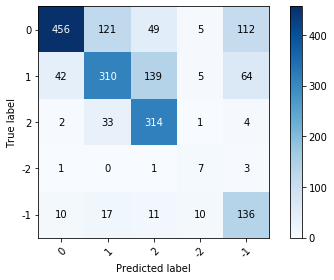

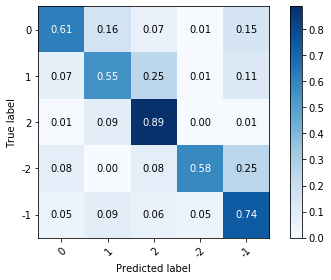

In [157]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_blstm, classes=class_names)
# plt.savefig('cm-blstm.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_blstm, classes=class_names, normalize=True)
# plt.savefig('cm-blstm-normalized.png')
plt.show()

Confusion matrix, without normalization
[[470 117  37   4 115]
 [ 69 319 111   4  57]
 [  4  48 298   1   3]
 [  0   0   1   7   4]
 [ 25  21   3   5 130]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.63 0.16 0.05 0.01 0.15]
 [0.12 0.57 0.2  0.01 0.1 ]
 [0.01 0.14 0.84 0.   0.01]
 [0.   0.   0.08 0.58 0.33]
 [0.14 0.11 0.02 0.03 0.71]]
AxesImage(54,36;334.8x217.44)


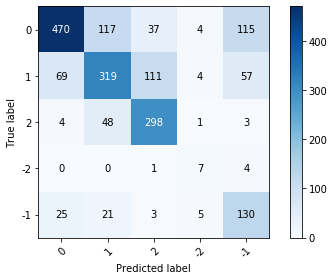

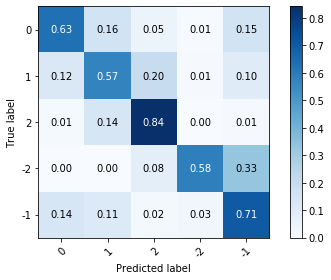

In [158]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_cnn, classes=class_names)
# plt.savefig('cm-cnn.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_cnn, classes=class_names, normalize=True)
# plt.savefig('cm-cnn-normalized.png')
plt.show()

## F1 Score

In [159]:
print("(Weighted) F1 score of FastTextEmb B-LSTM model:")
f1_score(y_test_label, y_pred_blstm, average='weighted')

(Weighted) F1 score of FastTextEmb B-LSTM model:


0.6657894842353378

In [160]:
print("(Weighted) F1 score of FastTextEmb CNN model:")
f1_score(y_test_label, y_pred_cnn, average='weighted')

(Weighted) F1 score of FastTextEmb CNN model:


0.6652778764999756

# Model Visualization

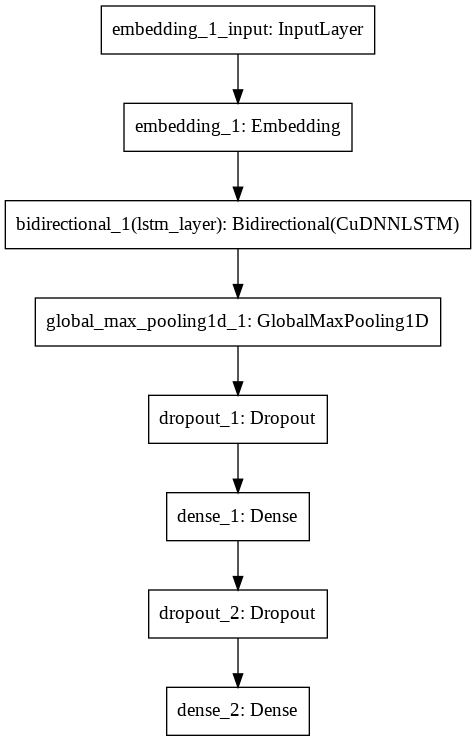

In [48]:
plot_model(model_blstm, to_file='multiclass-blstm.png')

In [0]:
# Decomment following line if you want to download model figure
# files.download('multiclass-blstm.png')

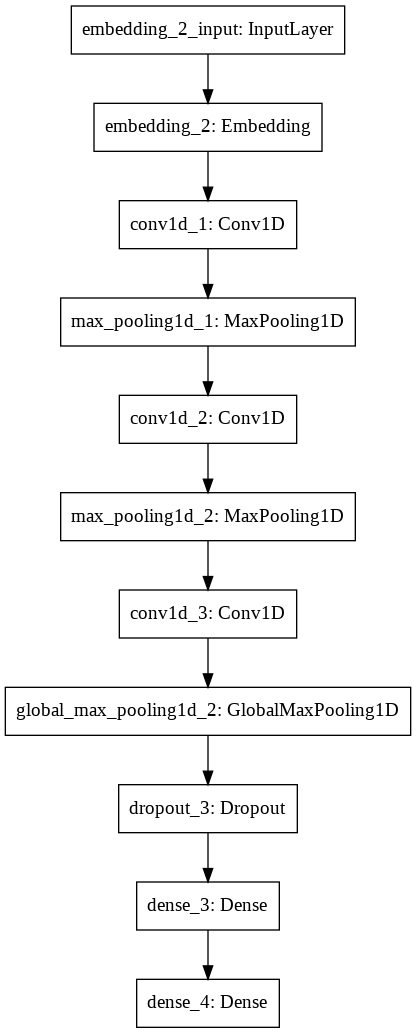

In [50]:
plot_model(model_cnn, to_file='multiclass-cnn.png')

In [0]:
# Decomment following line if you want to download model figure
# files.download('multiclass-cnn.png')